In [ ]:
!pip install torch torchaudio librosa transformers matplotlib


In [3]:
import torch
import torchaudio
import librosa
import matplotlib.pyplot as plt
import numpy as np


In [4]:
import librosa
import numpy as np

audio_path = "/content/LJ025-0076.wav"

# Load audio directly at 16kHz and mono
waveform, sample_rate = librosa.load(
    audio_path,
    sr=16000,
    mono=True
)

print("Sample Rate:", sample_rate)
print("Audio Length (seconds):", len(waveform) / sample_rate)


Sample Rate: 16000
Audio Length (seconds): 8.3966875


In [5]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch


In [ ]:
processor = Wav2Vec2Processor.from_pretrained(
    "facebook/wav2vec2-base-960h"
)

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base-960h"
)

model.eval()


In [7]:
inputs = processor(
    waveform,
    sampling_rate=16000,
    return_tensors="pt",
    padding=True
)


In [8]:
with torch.no_grad():
    logits = model(inputs.input_values).logits


In [9]:
predicted_ids = torch.argmax(logits, dim=-1)

decoded_output = processor.batch_decode(predicted_ids)

print("Recognized Phonemes / Tokens:")
print(decoded_output[0])


Recognized Phonemes / Tokens:
MANY ANIMALS OF EVEN COMPLEX STRUCTURE WHICH LIVE PARASITICALLY WITHIN OTHERS ARE WHOLLY DEVOID OF AN ALIMENTARY CAVITY


In [10]:
token_ids = predicted_ids[0].cpu().numpy()
tokens = processor.tokenizer.convert_ids_to_tokens(token_ids)

print(tokens[:40])   # view first few tokens


['<pad>', '<pad>', 'M', '<pad>', '<pad>', '<pad>', 'A', '<pad>', 'N', 'N', '<pad>', '<pad>', 'Y', '<pad>', '|', '|', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 'A', '<pad>', 'N', 'N', '<pad>', 'I', 'I', 'M', 'M', '<pad>', '<pad>', '<pad>', 'A', 'L', 'L', '<pad>', '<pad>']


In [12]:
num_frames = logits.shape[1]
frame_duration = len(waveform) / num_frames

print("Frame duration (samples per frame):", frame_duration)


Frame duration (samples per frame): 320.6372315035799


In [13]:
target_phoneme = "T"

indices = [i for i, t in enumerate(tokens) if t == target_phoneme]

start_frame = indices[0]
end_frame = indices[-1]

start_sample = int(start_frame * frame_duration)
end_sample = int(end_frame * frame_duration)

phoneme_waveform = waveform[start_sample:end_sample]


In [14]:
import soundfile as sf

sf.write("phoneme_T.wav", phoneme_waveform, 16000)


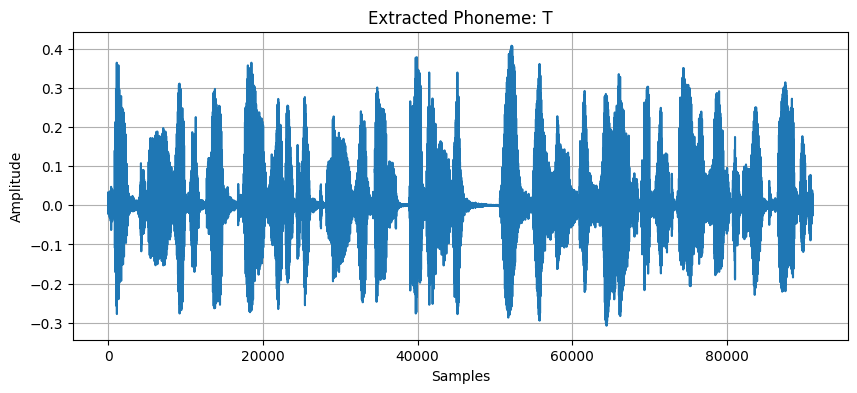

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(phoneme_waveform)
plt.title("Extracted Phoneme: T")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [16]:
phonemes_to_extract = ["T", "EH", "S"]

extracted = {}

for p in phonemes_to_extract:
    idx = [i for i, t in enumerate(tokens) if t == p]
    if len(idx) > 0:
        start = int(idx[0] * frame_duration)
        end = int(idx[-1] * frame_duration)
        extracted[p] = waveform[start:end]


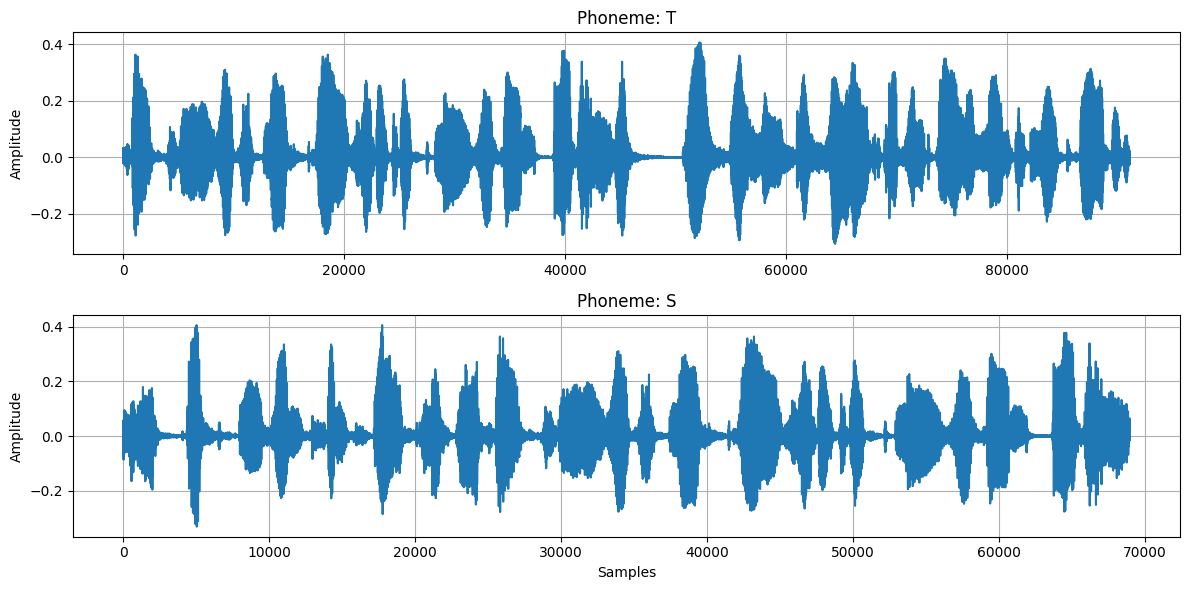

In [17]:
plt.figure(figsize=(12,6))

for i, (p, w) in enumerate(extracted.items(), 1):
    plt.subplot(len(extracted), 1, i)
    plt.plot(w)
    plt.title(f"Phoneme: {p}")
    plt.ylabel("Amplitude")
    plt.grid(True)

plt.xlabel("Samples")
plt.tight_layout()
plt.show()


In [18]:
for p, w in extracted.items():
    sf.write(f"phoneme_{p}.wav", w, 16000)
